In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
import offline_teachers as teach
import datasets as ds
import utils as ut
import data_output as op
import hypothesis as hp

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
num_teaching_itrs = 20
num_random_test_ims = 20
num_init_hyps = 100
density_sigma = 1.0
interp_sigma = 1.0
alpha = 0.5
image_scale = 2.0
hyp_type = 'k_cluster'  # rand, cluster, cluster_rand, sparse
# dataset_dir = dataset_root + dataset_name + '/'
url_root = ''  # set this to the location of the images on the web

save_ops = True
add_bias = True
remove_mean = True
do_pca = False
pca_dims = 2

experiment_id = hyp_type
op_dir = 'output/' + str(experiment_id) +'/'
if save_ops:
    print('saving output to', op_dir)
    if not os.path.isdir(op_dir):
        os.makedirs(op_dir)


def preprocess(X, remove_mean, do_pca, add_bias):

    # standardize
    if remove_mean:
        X = X - X.mean(0)
        X = X / X.std(0)

    # do PCA
    if do_pca and X.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        pca.fit(X)
        X = pca.transform(X)
        X = X - X.mean(0)
        X = X / X.std(0)

    # add 1 for bias (intercept) term
    if add_bias:
        X = np.hstack((X, np.ones(X.shape[0])[..., np.newaxis]))

    return X

def visualize_hyps(hyps):
    pca = PCA(n_components=2, random_state=42)
    hyps_2d = pca.fit_transform(np.vstack(hyps))
    plt.plot(hyps_2d)

saving output to output/k_cluster/


In [3]:
def pred_y(preds):
    # w_e = np.array([0.        , 0.3424866 , 0.        , 0.2356979 , 0.        ,
        # 0.        , 0.        , 0.42181548], dtype=np.float32)
    w_e = np.array([0.1101, 0.1751, 0.0000, 0.0000, 0.0000, 0.5072, 0.2076, 0.0000], dtype=np.float32)
    prob = preds @ w_e
    y_pred = prob
    y_pred[prob < 0.5] = 0
    y_pred[prob >= 0.5] = 1
    return y_pred.astype(np.int)

datasets = {}

fids, inputs, labels, embeds, preds = pickle.load(open('../../data/prostatex/train_findings_emb10.pkl', "rb"))
dataset = {}
# X = embeds.reshape(inputs.shape[0], -1)
dataset['X'] = embeds
dataset['X'] = preprocess(dataset['X'], remove_mean, do_pca, add_bias)
dataset['Y'] = labels
dataset['im_files'] = inputs[:,0,:,:]
dataset['explain_files'] = np.asarray([''] * labels.shape[0])
dataset['class_names'] = np.asarray([''] * np.unique(labels).shape[0])
# dataset['interp'] = saliency
# dataset['explain_interp'] = ut.compute_interpretability(dataset['interp'], dataset['Y'], pred_y(preds), interp_sigma)
dataset['explain_interp'] = np.ones(labels.shape[0])
datasets['train'] = dataset

fids, inputs, labels, embeds, preds = pickle.load(open('../../data/prostatex/valid_findings_emb10.pkl', "rb"))
dataset = {}
# X = embeds.reshape(inputs.shape[0], -1)
dataset['X'] = embeds
dataset['X'] = preprocess(dataset['X'], remove_mean, do_pca, add_bias)
dataset['Y'] = labels
dataset['im_files'] = inputs[:,0,:,:]
dataset['explain_files'] = np.asarray([''] * labels.shape[0])
dataset['class_names'] = np.asarray([''] * np.unique(labels).shape[0])
dataset['explain_interp'] = np.ones(labels.shape[0])
datasets['test'] = dataset

In [4]:
import random
random.seed(42)
np.random.seed(42)

# load data
dataset_train, dataset_test = datasets['train'].copy(), datasets['test'].copy()
if len(np.unique(dataset_train['Y'])) > 2:
    one_v_all = True  # multi class
else:
    one_v_all = False # binary

 # density of points
dataset_train['X_density'] = ut.compute_density(dataset_train['X'], dataset_train['Y'], density_sigma, True)

# generate set of hypotheses
hyps, prior_h = hp.generate_hyps(dataset_train, alpha, num_init_hyps, hyp_type, one_v_all)
print(len(hyps), hyp_type, 'hypotheses\n')

# remove examples that are inconsistent with best hypothesis
if one_v_all:
    err_hyp = hp.compute_hyps_error_one_vs_all(hyps, dataset_train['X'], dataset_train['Y'], alpha)
else:
    err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
dataset_train = ds.remove_exs(dataset_train, hyps, err_hyp, alpha, 'train', one_v_all)

# re compute hypothesis errors - after removing inconsistent examples
if one_v_all:
    err_hyp = hp.compute_hyps_error_one_vs_all(hyps, dataset_train['X'], dataset_train['Y'], alpha)
    err_hyp_test = hp.compute_hyps_error_one_vs_all(hyps, dataset_test['X'], dataset_test['Y'], alpha)
else:
    err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
    err_hyp_test = hp.compute_hyps_error(hyps, dataset_test['X'], dataset_test['Y'], alpha)

# compute the likelihood for each datapoint according to each hypothesis
if one_v_all:
    likelihood  = ut.compute_likelihood_one_vs_all(hyps, dataset_train['X'], dataset_train['Y'], alpha)
else:
    likelihood = ut.compute_likelihood(hyps, dataset_train['X'], dataset_train['Y'], alpha)

# teachers
teachers = {}
if one_v_all:
    teachers['rand_1vall'] = teach.RandomImageTeacherOneVsAll(dataset_train, alpha, prior_h)
    teachers['strict_1vall'] = teach.StrictTeacherOneVsAll(dataset_train, alpha, prior_h)
    # teachers['explain_1vall'] = teach.ExplainTeacherOneVsAll(dataset_train, alpha, prior_h)
else:
    teachers['random'] = teach.EfficientRandomImageTeacher(dataset_train, alpha, prior_h, hyps)
    teachers['strict'] = teach.EfficientStrictTeacher(dataset_train, alpha, prior_h, hyps)
    # teachers['explain'] = teach.ExplainTeacher(dataset_train, alpha, prior_h)

# run teaching
for alg_name in teachers.keys():
    print(alg_name)
    teachers[alg_name].run_teaching(num_teaching_itrs, dataset_train, likelihood, hyps, err_hyp, err_hyp_test)

870 possible combinations of PW classifers
101 k_cluster hypotheses

392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
0 train examples removed
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
392 392
39

In [20]:
# pd.DataFrame(teachers['random'].stats['diff_all']).to_csv('random_1.csv')
# pd.DataFrame(teachers['strict'].stats['diff_all']).to_csv('strict_1.csv')

# # np.array(teachers['strict'].teaching_exs)
# selected = [ 44, 197,  43, 146, 228,   1, 243,  60, 237,  61, 132, 219, 156,
#        171, 164, 211, 152, 202,  65, 224]

# # save strategy files
# if not save_ops:
#     print('\nnot saving outputs')
# else:
#     print('\nsaving outputs')
#     for alg_name in teachers.keys():
#         op.save_teaching_sequence(teachers[alg_name], alg_name, op_dir + alg_name + '.strat')

#     # op.save_teaching_images(dataset_train, dataset_test, op_dir + 'teaching_images.json', url_root)
#     op.save_settings(dataset_train, dataset_test, experiment_id, num_random_test_ims, image_scale, op_dir + 'settings.json')
#     np.savez(op_dir + 'params.npz', dataset_train=dataset_train, dataset_test=dataset_test, hyps=hyps, teachers=teachers)


saving outputs


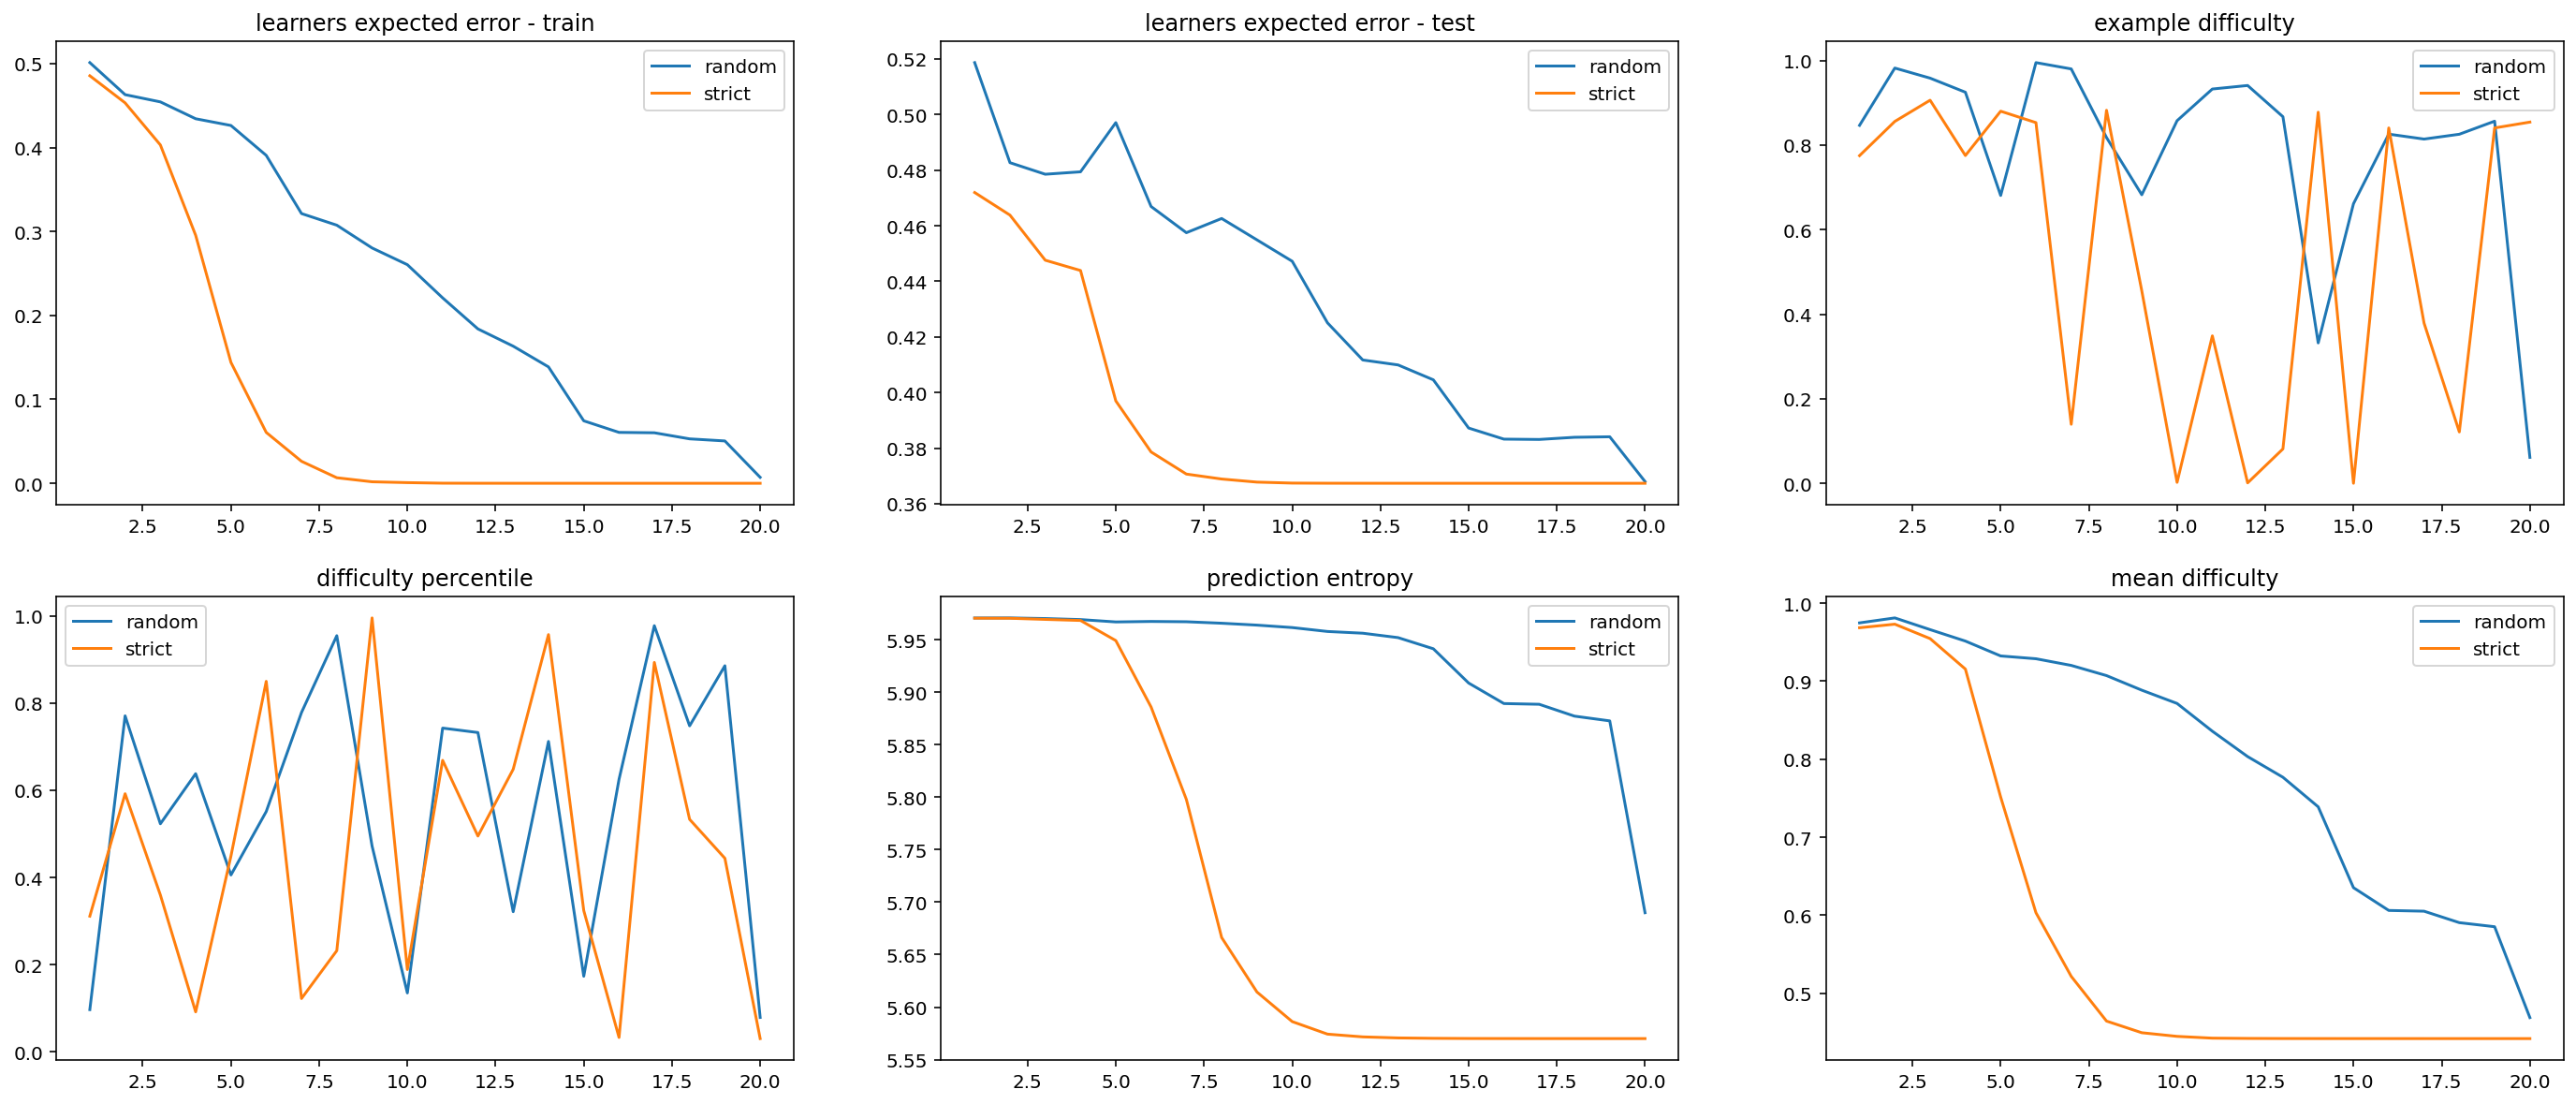

In [26]:
# plot in 2D
fig_id = 0
if (dataset_train['X'].shape[1] <= 3):
    for alg_name in teachers.keys():
        if one_v_all:
            ut.plot_2D_data(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].posterior(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
        else:
            ut.plot_2D_data_hyper(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].posterior(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
        fig_id += 1

fig, ax = plt.subplots(2, 3, figsize=(24, 10))

ax[0, 0].set_title('learners expected error - train')
for alg_name in teachers.keys():
    exp_err = teachers[alg_name].stats['exp_err']
    ax[0, 0].plot(np.arange(len(exp_err))+1, exp_err, label=alg_name)
ax[0, 0].legend()

ax[0, 1].set_title('learners expected error - test')
for alg_name in teachers.keys():
    exp_err_test = teachers[alg_name].stats['exp_err_test']
    ax[0, 1].plot(np.arange(len(exp_err_test))+1, exp_err_test, label=alg_name)
ax[0, 1].legend()

ax[0, 2].set_title('example difficulty')
for alg_name in teachers.keys():
    difficulty = teachers[alg_name].stats['difficulty']
    ax[0, 2].plot(np.arange(len(difficulty))+1, difficulty, label=alg_name)
ax[0, 2].legend()
fig.show()

ax[1, 0].set_title('difficulty percentile')
for alg_name in teachers.keys():
    diff_pctl = teachers[alg_name].stats['diff_pctl']
    ax[1, 0].plot(np.arange(len(diff_pctl))+1, diff_pctl, label=alg_name)
ax[1, 0].legend()
fig.show()

ax[1, 1].set_title('prediction entropy')
for alg_name in teachers.keys():
    pred_ent = teachers[alg_name].stats['pred_ent']
    ax[1, 1].plot(np.arange(len(pred_ent))+1, pred_ent, label=alg_name)
ax[1, 1].legend()
fig.show()

ax[1, 2].set_title('mean difficulty')
for alg_name in teachers.keys():
    diff_mean = teachers[alg_name].stats['diff_mean']
    ax[1, 2].plot(np.arange(len(diff_mean))+1, diff_mean, label=alg_name)
ax[1, 2].legend()
fig.show()

In [9]:
from sklearn import svm

def run_trials(n, datasets):

    # load data
    dataset_train, dataset_test = datasets['train'].copy(), datasets['test'].copy()
    one_v_all = False # binary

    random_teachers = []
    strict_teachers = []

    for i in range(n):

        GT = dataset_train['Y']
        np.random.shuffle(GT)

        # density of points
        dataset_train['X_density'] = ut.compute_density(dataset_train['X'], dataset_train['Y'], density_sigma, True)

        # generate set of hypotheses
        hyps, prior_h = hp.generate_hyps(dataset_train, alpha, num_init_hyps, hyp_type, one_v_all)

        clf = svm.LinearSVC(fit_intercept=False, penalty='l1', loss='squared_hinge', dual=False)
        clf.fit(dataset_train['X'], dataset_train['Y'])
        hyps.append(np.vstack((-clf.coef_.copy(), clf.coef_.copy())))
        prior_h = np.ones(len(hyps)) / float(len(hyps))

        print(len(hyps), hyp_type, 'hypotheses\n')

        # remove examples that are inconsistent with best hypothesis
        err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
        dataset_train = ds.remove_exs(dataset_train, hyps, err_hyp, alpha, 'train', one_v_all)

        # re compute hypothesis errors - after removing inconsistent examples
        err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
        err_hyp_test = hp.compute_hyps_error(hyps, dataset_test['X'], dataset_test['Y'], alpha)

        # compute the likelihood for each datapoint according to each hypothesis
        likelihood = ut.compute_likelihood(hyps, dataset_train['X'], dataset_train['Y'], alpha)

        teachers = {}
        teachers['random'] = teach.EfficientRandomImageTeacher(dataset_train, alpha, prior_h, hyps)
        teachers['strict'] = teach.EfficientStrictTeacher(dataset_train, alpha, prior_h, hyps)

        for alg_name in teachers.keys():
            print(alg_name)
            teachers[alg_name].run_teaching(num_teaching_itrs, dataset_train, likelihood, hyps, err_hyp, err_hyp_test)

        random_teachers.append(teachers['random'])
        strict_teachers.append(teachers['strict'])

    return random_teachers, strict_teachers

    

In [10]:
import random
random.seed(42)
np.random.seed(42)

n = 100
rts, sts = run_trials(n, datasets)
ts = {}
ts['random'] = rts
ts['strict'] = sts

870 possible combinations of PW classifers
102 k_cluster hypotheses

134 train examples removed
random
strict
870 possible combinations of PW classifers
102 k_cluster hypotheses

70 train examples removed
random
strict
870 possible combinations of PW classifers
102 k_cluster hypotheses

36 train examples removed
random
strict
870 possible combinations of PW classifers
102 k_cluster hypotheses

29 train examples removed
random
strict
870 possible combinations of PW classifers
102 k_cluster hypotheses

6 train examples removed
random
strict
870 possible combinations of PW classifers
102 k_cluster hypotheses

7 train examples removed
random
strict
870 possible combinations of PW classifers
102 k_cluster hypotheses

5 train examples removed
random
strict
870 possible combinations of PW classifers
102 k_cluster hypotheses

9 train examples removed
random
strict
870 possible combinations of PW classifers
102 k_cluster hypotheses

1 train examples removed
random
strict
870 possible combinatio

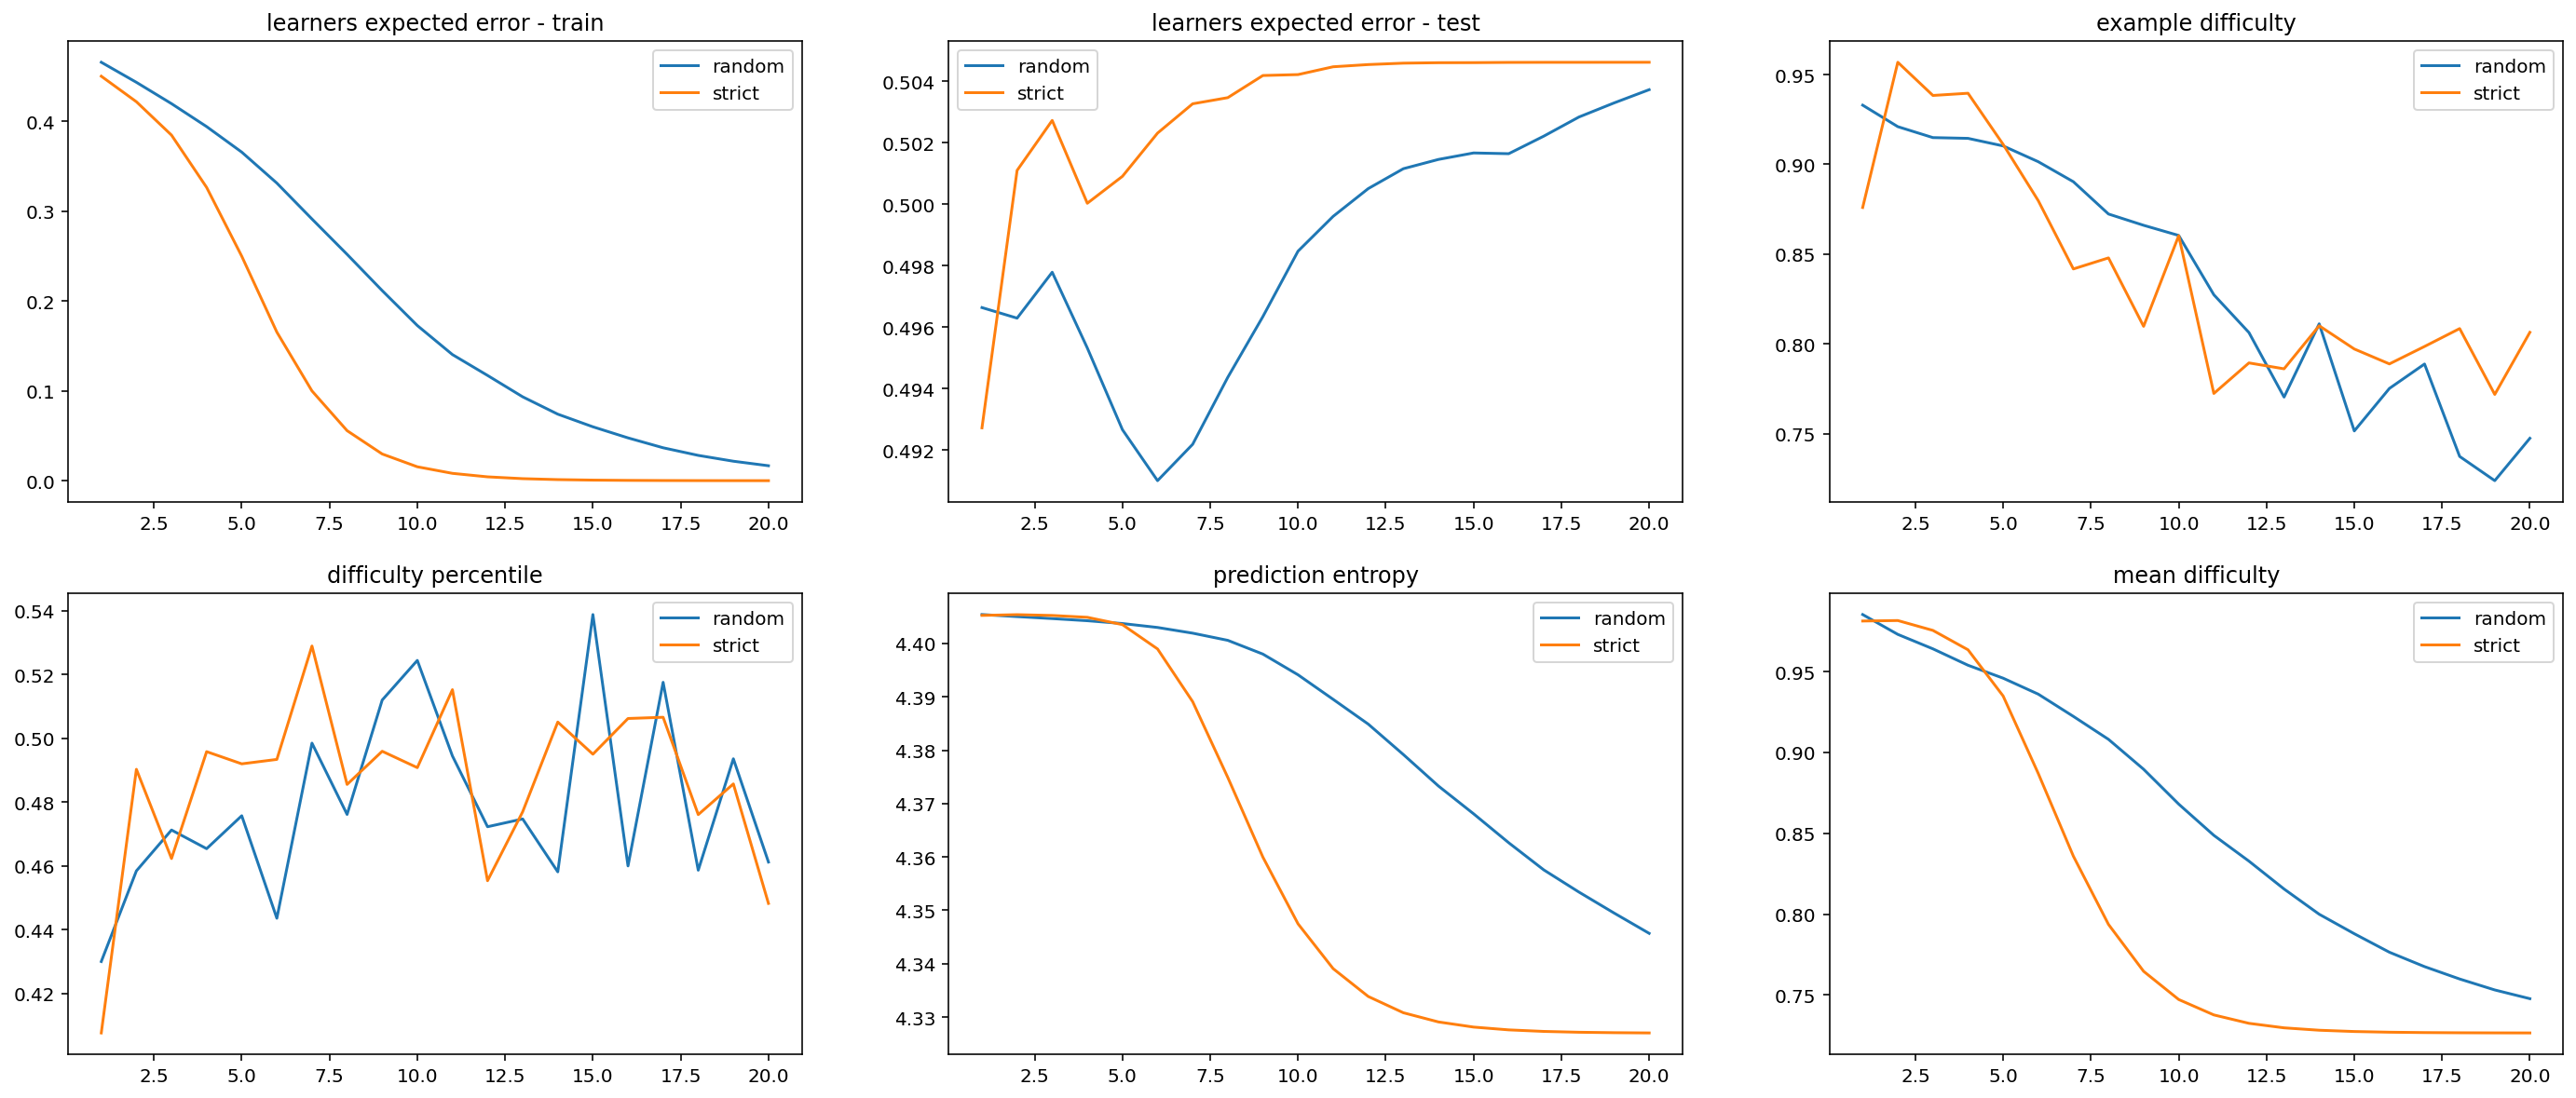

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(24, 10))

ax[0, 0].set_title('learners expected error - train')
for alg_name in ts.keys():
    exp_err = np.array([t.stats['exp_err'] for t in ts[alg_name]]).mean(0)
    ax[0, 0].plot(np.arange(len(exp_err))+1, exp_err, label=alg_name)
ax[0, 0].legend()

ax[0, 1].set_title('learners expected error - test')
for alg_name in ts.keys():
    exp_err_test = np.array([t.stats['exp_err_test'] for t in ts[alg_name]]).mean(0)
    ax[0, 1].plot(np.arange(len(exp_err_test))+1, exp_err_test, label=alg_name)
ax[0, 1].legend()

ax[0, 2].set_title('example difficulty')
for alg_name in ts.keys():
    difficulty = np.array([t.stats['difficulty'] for t in ts[alg_name]]).mean(0)
    ax[0, 2].plot(np.arange(len(difficulty))+1, difficulty, label=alg_name)
ax[0, 2].legend()
fig.show()

ax[1, 0].set_title('difficulty percentile')
for alg_name in ts.keys():
    diff_pctl = np.array([t.stats['diff_pctl'] for t in ts[alg_name]]).mean(0)
    ax[1, 0].plot(np.arange(len(diff_pctl))+1, diff_pctl, label=alg_name)
ax[1, 0].legend()
fig.show()

ax[1, 1].set_title('prediction entropy')
for alg_name in ts.keys():
    pred_ent = np.array([t.stats['pred_ent'] for t in ts[alg_name]]).mean(0)
    ax[1, 1].plot(np.arange(len(pred_ent))+1, pred_ent, label=alg_name)
ax[1, 1].legend()
fig.show()

ax[1, 2].set_title('mean difficulty')
for alg_name in ts.keys():
    diff_mean = np.array([t.stats['diff_mean'] for t in ts[alg_name]]).mean(0)
    ax[1, 2].plot(np.arange(len(diff_mean))+1, diff_mean, label=alg_name)
ax[1, 2].legend()
fig.show()

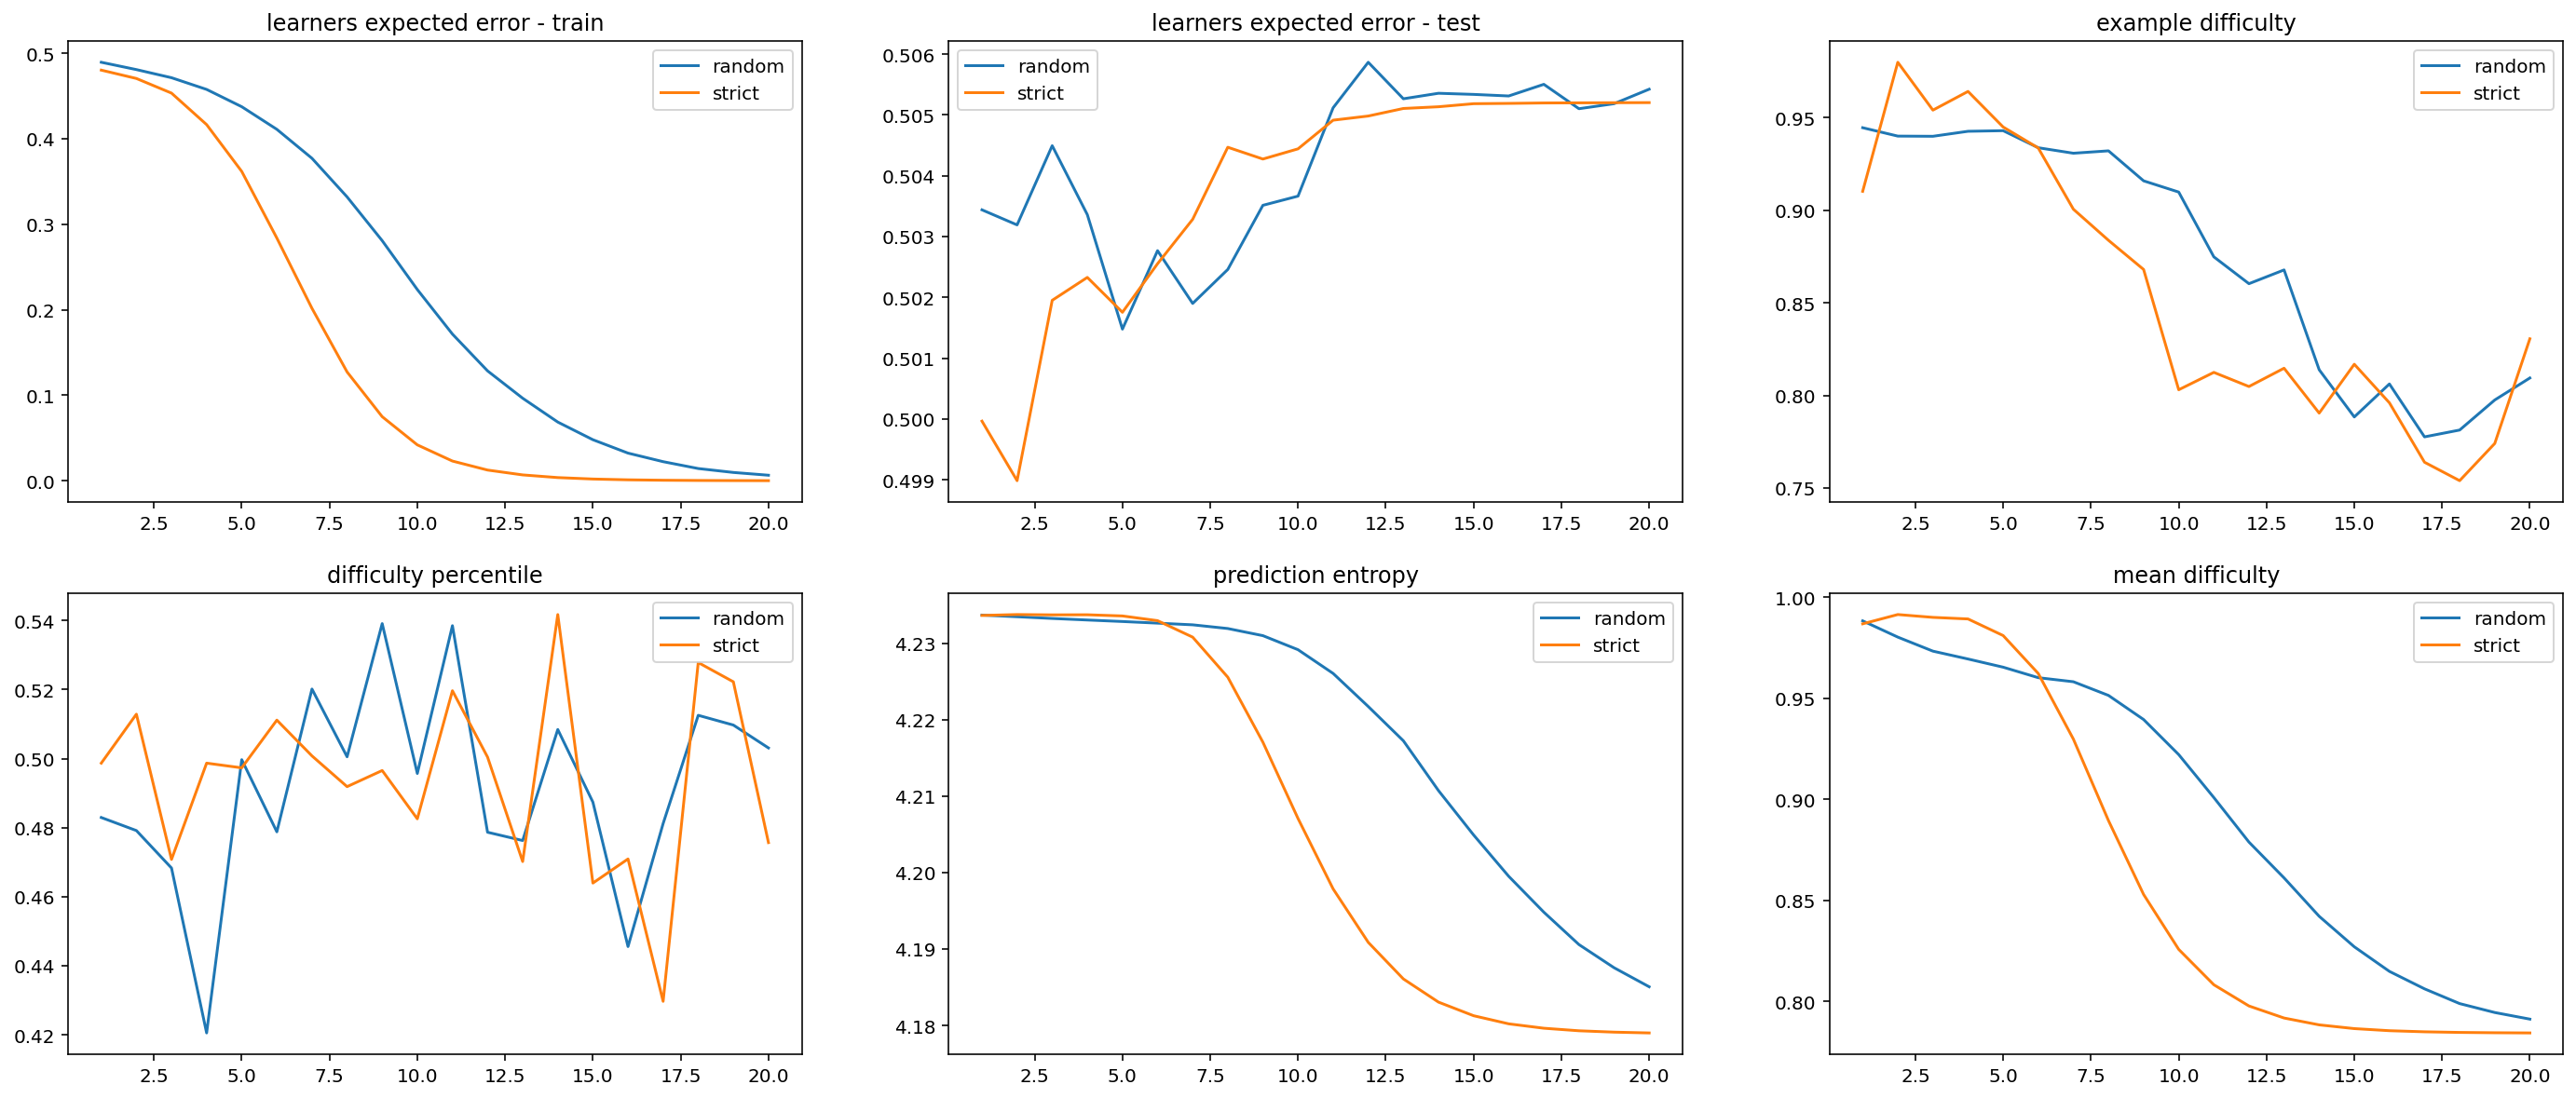

In [ ]:
# # plot in 2D
# fig_id = 0
# if (dataset_train['X'].shape[1] <= 3):
#     for alg_name in teachers.keys():
#         if one_v_all:
#             ut.plot_2D_data(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].posterior(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
#         else:
#             ut.plot_2D_data_hyper(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].posterior(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
#         fig_id += 1

# fig, ax = plt.subplots(1, 3, figsize=(24, 5))

# ax[0].set_title('learners expected error - train')
# for alg_name in teachers.keys():
#     exp_err = teachers[alg_name].exp_err
#     ax[0].plot(np.arange(len(exp_err))+1, exp_err, label=alg_name)
# ax[0].legend()
# # if save_ops:
# #     plt.savefig(op_dir + 'eer.pdf')

# # plt.figure(fig_id+1, figsize=(4, 3))
# ax[1].set_title('learners expected error - test')
# for alg_name in teachers.keys():
#     exp_err_test = teachers[alg_name].exp_err_test
#     ax[1].plot(np.arange(len(exp_err_test))+1, exp_err_test, label=alg_name)
# ax[1].legend()
# # if save_ops:
# #    plt.savefig(op_dir + 'eer_test.pdf')

# # plt.figure(fig_id+2, figsize=(4, 3))
# ax[2].set_title('example difficulty')
# for alg_name in teachers.keys():
#     difficulty = teachers[alg_name].difficulty
#     ax[2].plot(np.arange(len(difficulty))+1, difficulty, label=alg_name)
# ax[2].legend()
# fig.show()